In [1]:
import torch
import numpy as np
import cv2
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor

In [2]:
from helpers.config import load_config

In [3]:
import segmentation_models_pytorch as smp

In [4]:
def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask

In [5]:
class OilSegmentationModel():
    def __init__(self, transforms=None, conf=None, ckpt=None):
        self.conf = load_config(conf)
        self.ckpt = ckpt
        
        model = smp.Unet(encoder_name='efficientnet-b4', classes=5, encoder_weights=None)
        self.normalize = self.conf['input']['normalize']
        self.transforms = transforms
        
        checkpoint = torch.load(self.ckpt, map_location='cpu')
        state_dict = checkpoint['state_dict']
        model.load_state_dict(state_dict, strict=False)
        model = model.cuda()
        self.model = model.eval()
        
    def segment_single_image(self, image, mode='path'):
        
        if mode == 'path':
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        sample = self.transforms(image=image)
        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        
        with torch.no_grad():
            imgs = torch.unsqueeze(sample['image'], 0).cuda().float() #CxHxW > BxCxHxW
            #print(imgs.shape)
            output = self.model(imgs)
            #print(output.shape)
            pred = torch.softmax(output, dim=1) # 1x5x640x640
            mask = pred.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float)
            #print(pred.shape)
            #argmax = torch.argmax(pred, dim=1) # 1x640x640
            #print(argmax.shape)
            #mask = argmax.permute(1,2,0).cpu().numpy().astype(np.float) # 1x640x640 > 640x640x1
            #print(mask.shape)
        
        return mask

In [6]:
transform = A.Compose([
    A.Crop(0,0,640,640, p=1.0)
])

In [7]:
conf_path = 'helpers/res_conf.json'
ckpt_path= 'Efficientnet-b4/outputssegment_efficientnet-b4_efficientnet-b4_best_miou.pt'

In [8]:
oil_segmenter = OilSegmentationModel(transform, conf_path, ckpt_path)

In [9]:
img = oil_segmenter.segment_single_image('Oil Spill Detection Dataset/test/images/42_308,18_108_2.jpg')

C:\Users\spark lab\AppData\Local\Temp\ipykernel_15540\3926477201.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = pred.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float)


In [10]:
# plt.figure(figsize=(500,20))
# plt.imshow(convert_mask(img[:,:,0]))

In [11]:
#img_orig_mask = cv2.imread('../../oil_spill_dataset/test/labels/42_308,18_108_2.png')
#img_orig_mask = cv2.cvtColor(img_orig_mask, cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(500,20))
#plt.imshow(img_orig_mask[0:640, 0:640])

In [12]:
#640x640 > 650x1250

In [13]:
img = cv2.imread('image_sentinel.png')#cv2.imread('Oil Spill Detection Dataset/test/images/42_308,18_108_2.jpg')
patch_size = (640, 640)
overlap = 0.8   #640*0.8

segmentation_map = np.zeros((img.shape[0], img.shape[1], 5), dtype=np.float32)
for y in range(0, img.shape[0], int(patch_size[0]*overlap)):
    for x in range(0, img.shape[1], int(patch_size[0]*overlap)):
        patch = img[y:y+patch_size[0], x:x+patch_size[1]]
        if patch.shape[1] < patch_size[1] and patch.shape[0] == patch_size[0]:
            patch = img[y:y+patch_size[0], img.shape[1]-patch_size[1]:img.shape[1]]
            patch_seg_map = oil_segmenter.segment_single_image(patch, mode='img')
            segmentation_map[y:y+patch_size[0], img.shape[1]-patch_size[1]:img.shape[1]]+=patch_seg_map
        elif patch.shape[0]<patch_size[0] and patch.shape[1] == patch_size[1]:
            patch = img[img.shape[0]-patch_size[0]:img.shape[0], x:x+patch_size[1]]
            patch_seg_map = oil_segmenter.segment_single_image(patch, mode='img')
            segmentation_map[img.shape[0]-patch_size[0]:img.shape[0], x:x+patch_size[1]]+=patch_seg_map
        elif patch.shape[0]<patch_size[0] and patch.shape[1]<patch_size[1]:
            patch = img[img.shape[0]-patch_size[0]:img.shape[0], img.shape[1]-patch_size[1]:img.shape[1]]
            patch_seg_map = oil_segmenter.segment_single_image(patch, mode='img')
            segmentation_map[img.shape[0]-patch_size[0]:img.shape[0], img.shape[1]-patch_size[1]:img.shape[1]]+=patch_seg_map
        else:
            patch_seg_map = oil_segmenter.segment_single_image(patch, 'img')
            segmentation_map[y:y+patch_size[0], x:x+patch_size[1]] += patch_seg_map

C:\Users\spark lab\AppData\Local\Temp\ipykernel_15540\3926477201.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = pred.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.float)


In [14]:
np.unique(segmentation_map)

array([2.7777543e-29, 3.2164411e-29, 6.1010120e-29, ..., 3.9999995e+00,
       3.9999998e+00, 4.0000000e+00], dtype=float32)

In [15]:
segmentation_map.shape

(1873, 3548, 5)

In [16]:
segmentation_map = np.argmax(segmentation_map, axis=-1)

In [17]:
segmentation_map.shape

(1873, 3548)

In [18]:
np.unique(segmentation_map)

array([0, 1, 2, 3], dtype=int64)

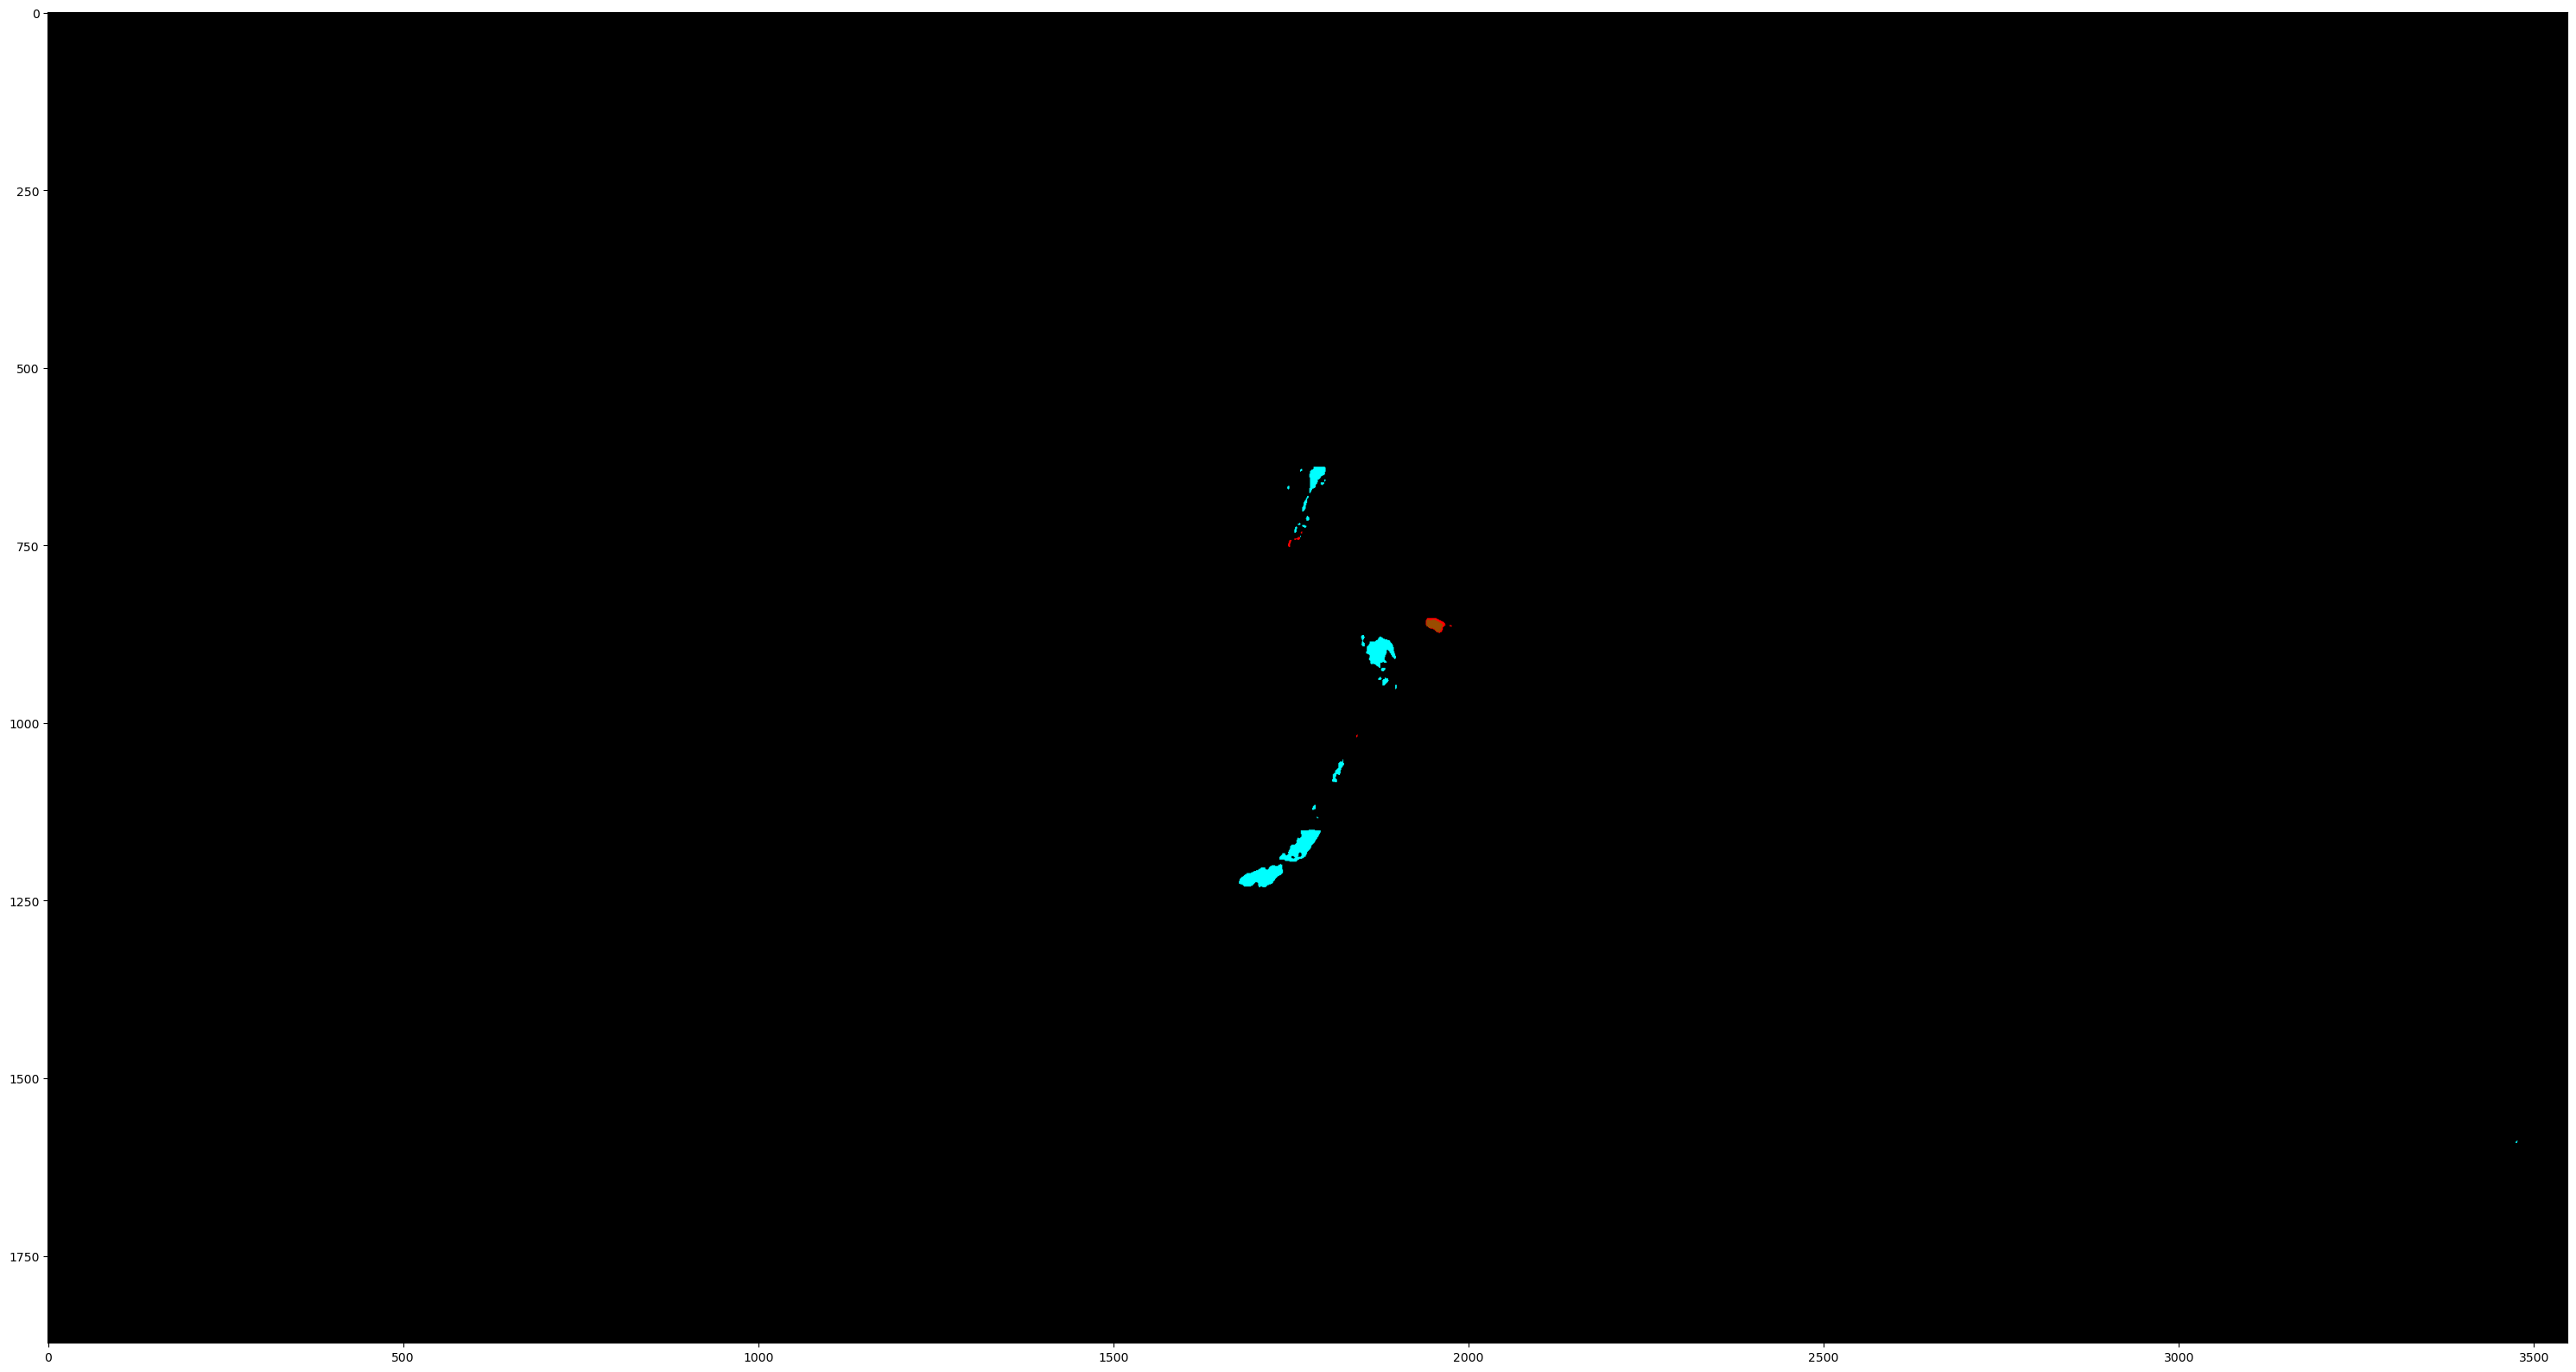

In [19]:
plt.figure(figsize=(500,20))
plt.imshow(convert_mask(segmentation_map))

In [23]:
np.unique((segmentation_map))

array([0, 1, 2, 3], dtype=int64)

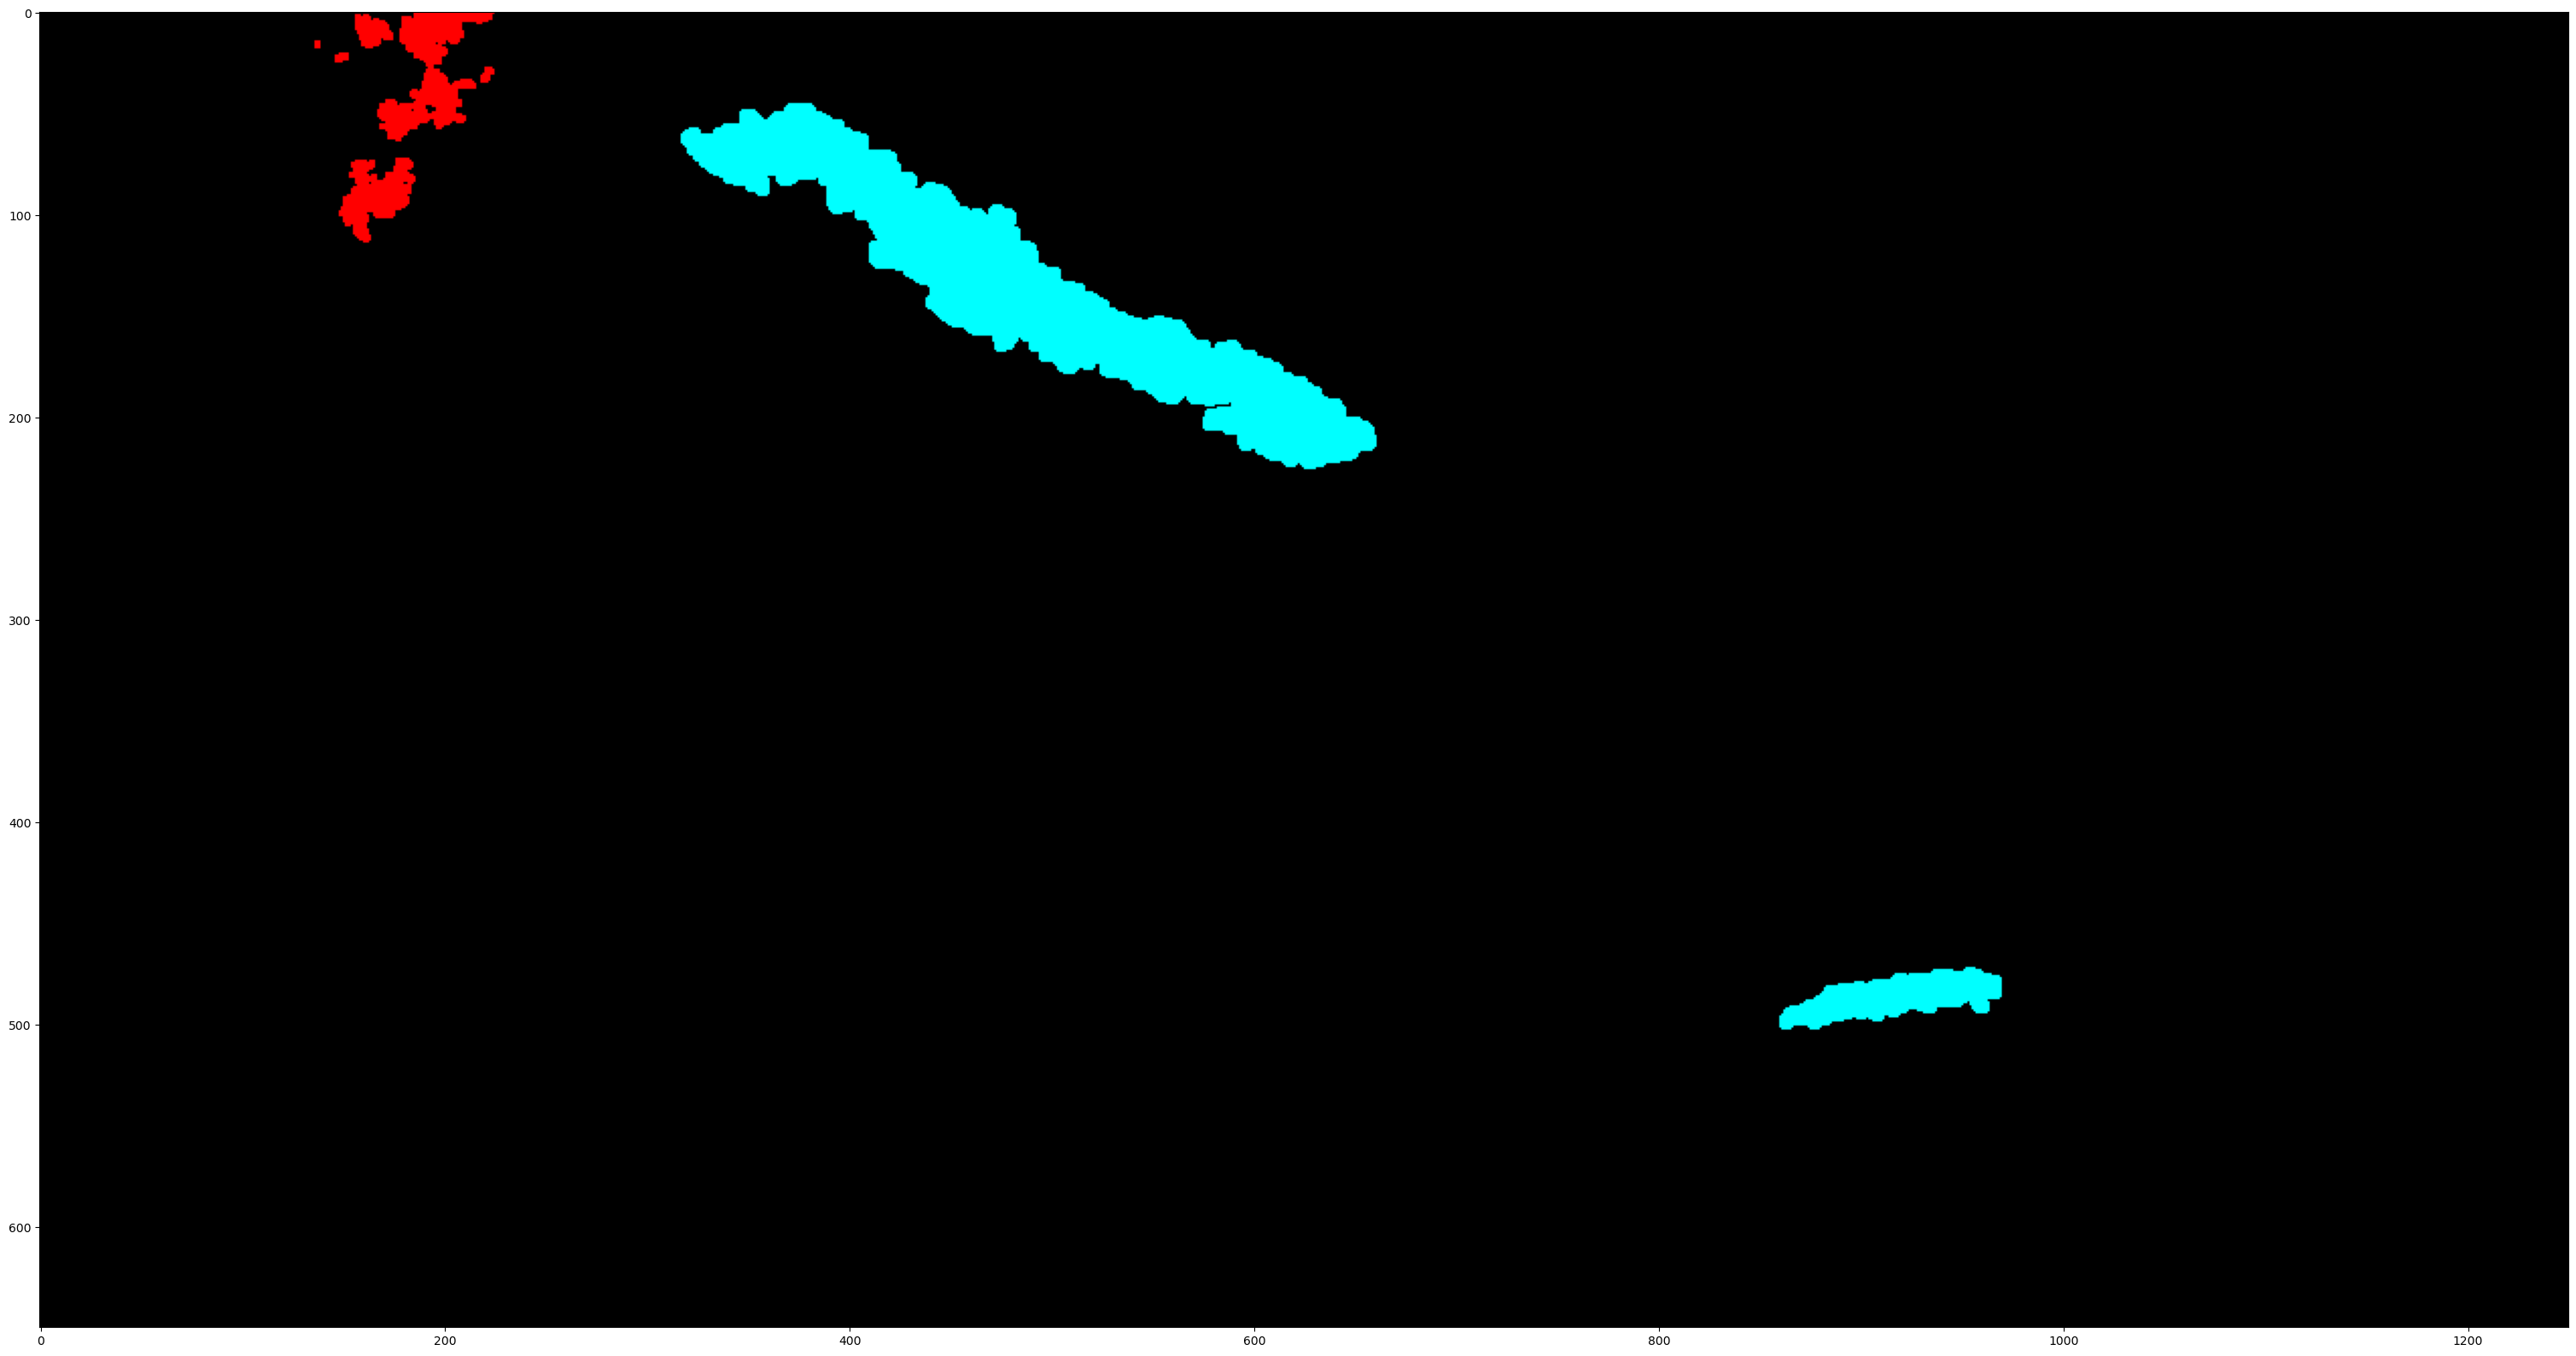

In [20]:
img_orig_mask = cv2.imread('Oil Spill Detection Dataset/test/labels/42_308,18_108_2.png')
img_orig_mask = cv2.cvtColor(img_orig_mask, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(500,20))
plt.imshow(img_orig_mask)

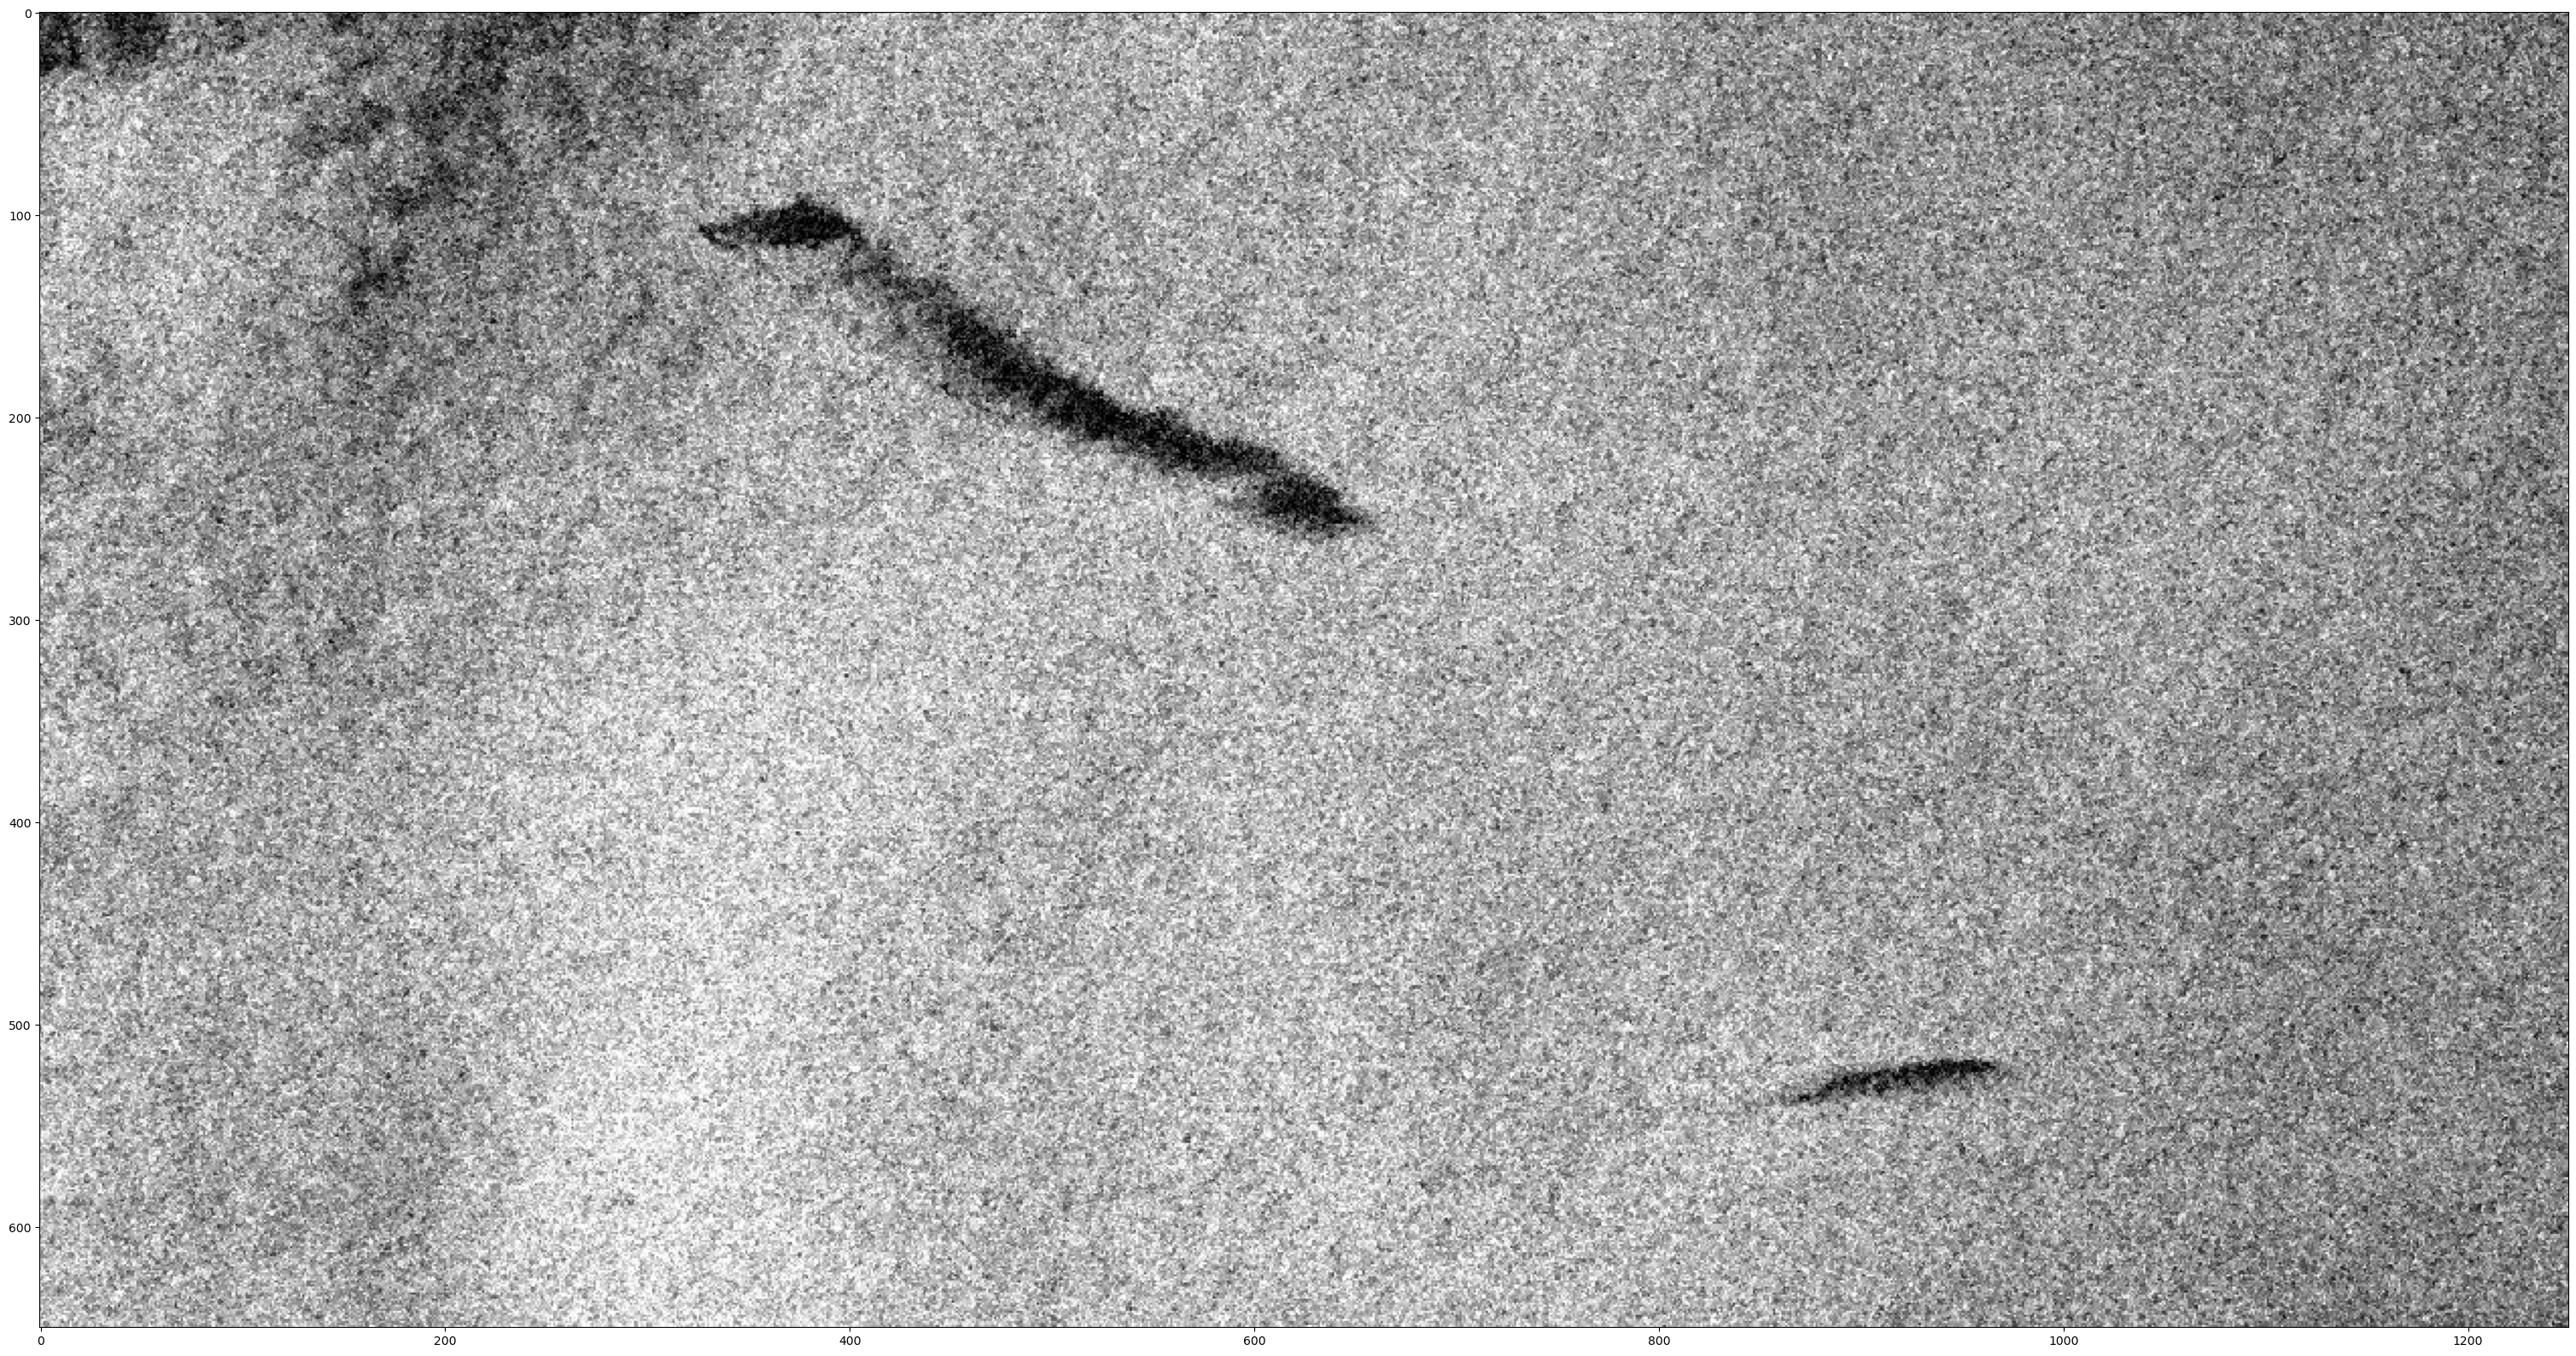

In [21]:
img_orig = cv2.imread('Oil Spill Detection Dataset/test/images/42_308,18_108_2.jpg')
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(500,20))
plt.imshow(img_orig)